# <span style="color:#8e44ad"> P7 - Implémentez un modèle de scoring </span>
## <span style="color:#8e44ad"> Notebook 2 - Modélisations V4</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
import re
from unidecode import unidecode
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')
%load_ext pycodestyle_magic

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from catboost import CatBoostClassifier
import shap

from imblearn.over_sampling import SMOTE  # pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_imb

pd.options.display.max_columns = None

# <span style="color: #8e44ad "> 1 - Préparation des données </span>

In [2]:
df = pd.read_csv('Data_preprocessed.csv')

# Correction des noms de colonnes
# df.columns = [unidecode(col) for col in df.columns]
df.columns = [re.sub('[^A-Za-z0-9_]+', '', col) for col in df.columns]

# Définition des datas train et submit
data = df[df.TARGET.notnull()]
data_submit = df[df.TARGET.isnull()]

print('Taille du jeu données : ', data.shape)
print('Taille du jeu à soummettre : ', data_submit.shape)

Taille du jeu données :  (307507, 798)
Taille du jeu à soummettre :  (48744, 798)


## <span style="color: #8e44ad "> 1-1 - Traitement des NAs </span>

In [3]:
def traitement_NA_par_type(df, head = 20):
    '''
    Fonction permettant de sortir un tableau classé de l'ensemble des features comportant des NA, par nombre et %
    ----------
    Paramètre:
    - df : dataframe
    - head : fige si nécessaire la taille du df de sortie (ou affichage si le commentaire sur display est enlevé)
    ----------
    Return:
    - une visualisation d'un tableau avec la liste des features et leurs taux de remplissage
    '''
    df_NA = pd.concat([df.isna().sum(),
                       ((df.isna().sum()/df.isna().count())*100),
                       df.dtypes], axis=1, keys=['Total_NA', '%_de_NA', 'Type'])

    df_NA.sort_values(['Total_NA'],ascending=[False],inplace=True)

    #display(df_NA[df_NA['Total_NA'] > 0].head(head))
    
    return df_NA[df_NA['Total_NA'] > 0]

In [4]:
# % de NA à ne pas dépasser sur une colonne donnée
NA_MAX = 80

In [5]:
# Sur les données d'entrainement
df_na_data = traitement_NA_par_type(data, None)

df_na_data = df_na_data[df_na_data['%_de_NA'] > NA_MAX]
print("Nombre de colonnes concernées :", df_na_data.shape[0])

Nombre de colonnes concernées : 37


In [6]:
# Sur les données Submit
df_na_submit = traitement_NA_par_type(data_submit.drop(["TARGET"], axis=1), None)

df_na_submit = df_na_submit[df_na_submit['%_de_NA'] > NA_MAX]
print("Nombre de colonnes concernées :", df_na_submit.shape[0])

Nombre de colonnes concernées : 6


In [7]:
# Agrégation des colonnes et suppression

data_missing = df_na_data.index
data_submit_missing = df_na_submit.index

data_missing = list(data_missing | data_submit_missing)
print("Nombre de colonnes concernées :", len(data_missing))
print("\n")

data = data.drop(columns = data_missing)
data_submit = data_submit.drop(columns = data_missing)

print('Taille du jeu données : ', data.shape)
print('Taille du jeu de soumission : ', data_submit.shape)

Nombre de colonnes concernées : 37


Taille du jeu données :  (307507, 761)
Taille du jeu de soumission :  (48744, 761)


## <span style="color: #8e44ad "> 1-2 - Scale et imputations </span>

In [8]:
# Définition des features initiales
# features_X_test_export = [f for f in data.columns if f not in ['TARGET', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
features = [f for f in data.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
# features = [f for f in features_X_test_export if f != 'SK_ID_CURR']

# Préparation des données
train = data[features]
submit = data_submit[features]

# Définition des imputers et du scaler
imputer = SimpleImputer(strategy = 'median')
scaler = StandardScaler()

# Imputation
imputer.fit(train)
train = imputer.transform(train)
submit = imputer.transform(submit)

# Scale
scaler.fit(train)
# train = scaler.transform(train)  # Fait à travers un pipeline
submit = scaler.transform(submit)

print('Training data shape: ', train.shape)
print('Submit data shape: ', submit.shape)

Training data shape:  (307507, 758)
Submit data shape:  (48744, 758)


In [9]:
# Sauvegarde des jeux préparés
# X_train = pd.DataFrame(train, columns = features)
# X_train.to_csv('./api/X_train.csv', sep=',', index=False)

# y_train = pd.DataFrame(data['TARGET'].values, columns = ['TARGET'])
# y_train.to_csv('./api/y_train.csv', sep=',', index=False)

X_test_api = pd.DataFrame(data_submit[features], columns = features)
X_test_api['SK_ID_CURR'] = data_submit['SK_ID_CURR'].values
x_test_api_export = X_test_api.sample(n = 3000)
x_test_api_export = x_test_api_export.sort_values(by='SK_ID_CURR', ascending = True)
x_test_api_export.to_csv('./api/X_test.csv', sep=',', index=False)
x_test_api_export.to_csv('./Dashboard/X_test.csv', sep=',', index=False)


# <span style="color: #8e44ad "> 2 - Choix du modèle </span>

## <span style="color: #8e44ad "> 2-1 - Influence de la taille du jeu d'entrainement </span>

In [10]:
test_size = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
AUC = []

for size in test_size:
    X_train, X_test, y_train, y_test = train_test_split(train, data['TARGET'], test_size=size, stratify=data['TARGET'], random_state=42)
    model = make_pipeline(StandardScaler(),LogisticRegression(random_state=0))
    model.fit(X_train, y_train)
    AUC.append([size, train.shape[0]*size, metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])])

AUC               

[[0.2, 61501.4, 0.773898254226336],
 [0.3, 92252.09999999999, 0.7726144172538112],
 [0.4, 123002.8, 0.7725989935883376],
 [0.5, 153753.5, 0.7708705826931883],
 [0.6, 184504.19999999998, 0.76959415592737],
 [0.7, 215254.9, 0.7669368105124352],
 [0.8, 246005.6, 0.7603260493811229],
 [0.9, 276756.3, 0.7441422905664364]]

Peu d'influence de la taille du jeu d'entrainement. Il faut rester au dessus des 20% soit env 92 000

## <span style="color: #8e44ad "> 2-2 - Cross validation</span>

Test de 5 modèles :  
* Régresion logistique
* Random Forest
* Light GBM
* XG Boost
* CatBoost

In [11]:
# Définition des modèles
models = [LogisticRegression(),
          RandomForestClassifier(),
          LGBMClassifier(n_estimators=10000, # LightGBM parameters found by Bayesian optimization (Kaggle ressource d'OpenClassRooms)
                         learning_rate=0.02,
                         num_leaves=34,
                         colsample_bytree=0.9497036,
                         subsample=0.8715623,
                         max_depth=8,
                         reg_alpha=0.041545473,
                         reg_lambda=0.0735294,
                         min_split_gain=0.0222415,
                         min_child_weight=39.3259775),
          xgb.XGBClassifier(verbosity=0),
          CatBoostClassifier(verbose=0)
         ]

In [12]:
# Cross Validation de l'ensemble des modèles
t0 = time.time()

results = []

for m in models:
    model = make_pipeline(StandardScaler(),m)
    cv_results = cross_validate(model, train, data['TARGET'], scoring='roc_auc', cv=3, return_train_score=True,return_estimator=True)
    results.append([m, cv_results["train_score"].mean(), cv_results["test_score"].mean(), cv_results["fit_time"].mean()])

print("Temps pour l'ensemble des cross validations :", time.time() - t0, " s")
results = pd.DataFrame(results, columns=['Model','Train score','Test_score','Fit_time'])
results

Temps pour l'ensemble des cross validations : 3552.3607409000397  s


,Model,Train score,Test_score,Fit_time
0,LogisticRegression(),0.780052,0.770565,11.799886
1,RandomForestClassifier(),1.000000,0.713125,222.010587
2,"LGBMClassifier(colsample_bytree=0.9497036, lea...",0.997160,0.773185,579.995335
3,"XGBClassifier(base_score=None, booster=None, c...",0.905908,0.770579,123.474026
4,<catboost.core.CatBoostClassifier object at 0x...,0.872378,0.785439,110.298419


# <span style="color: #8e44ad "> 3 - Features importance </span>

## <span style="color: #8e44ad "> 3-1 - RFECV</span>

In [13]:
# Création des jeux de train et de validation
X_train, X_test, y_train, y_test = train_test_split(train, data['TARGET'], test_size=0.9, stratify=data['TARGET'], random_state=42)

In [14]:
X_train.shape

(30750, 758)

In [15]:
# Test du nombre de features
plt.rcParams["figure.figsize"] = (10,8)

min_features_to_select = 1 

rfecv = RFECV(
    estimator=CatBoostClassifier(verbose=0),
    step=5,  # Le step de 5 permet de supprimer les features 5 par 5 pour gagner en temps de calcul
    cv=3,
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

RFECV(cv=3,
      estimator=<catboost.core.CatBoostClassifier object at 0x7f3f567ec730>,
      scoring='roc_auc', step=5)

Nombre de features optimal : 683


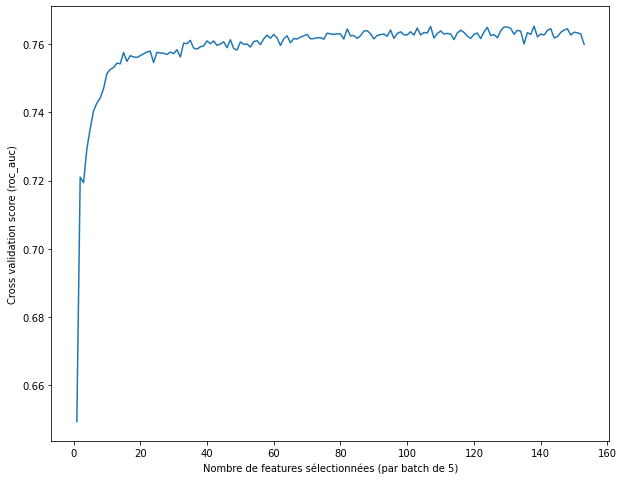

In [16]:
# Affichage des scores
print("Nombre de features optimal : %d" % rfecv.n_features_)

scores = rfecv.grid_scores_.mean(axis=1)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Nombre de features sélectionnées (par batch de 5)")
plt.ylabel("Cross validation score (roc_auc)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    scores,
)
plt.show()

On observe un palier à partir du batch 60 donc env 300 features

In [18]:
# Récupération des 300 premières features

feature_importances = pd.DataFrame({'feature': features, 'rank': rfecv.ranking_}) # Dataframe avec les features et les rangs
feature_importances = feature_importances[feature_importances['rank'] == 1]  # Filtre sur les rank=1 (les features conservées)
feature_importances['importance'] = rfecv.estimator_.feature_importances_ # Ajoute les importances
feature_importances.drop(['rank'], axis=1, inplace=True)
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances = feature_importances.head(300)
liste_300_feature_importances = feature_importances.feature

In [19]:
def pickle_sav(title, data):
    pikd = open(title + '.pickle', 'wb')
    pickle.dump(data, pikd)
    pikd.close()

In [20]:
def pickle_load(file):
    pikd = open(file, 'rb')
    data = pickle.load(pikd)
    pikd.close()
    return data

In [21]:
pickle_sav('liste_300_feature_importances', liste_300_feature_importances)

In [22]:
# Second run de rfecv avec la base filtrée
t0 = time.time()

data_rfecv = data[liste_300_feature_importances]
X_train, X_test, y_train, y_test = train_test_split(data_rfecv, data['TARGET'], test_size=0.8, stratify=data['TARGET'], random_state=22)

# Test du nombre de features
plt.rcParams["figure.figsize"] = (10,8)

min_features_to_select = 1 

rfecv_2nd_run = RFECV(
    estimator=CatBoostClassifier(verbose=0),
    step=1,  # Le step 1 permet de supprimer les features 1 par 1
    cv=3,
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
)
rfecv_2nd_run.fit(X_train, y_train)

print("Temps de traitement :", time.time()-t0)

Temps de traitement : 14120.631461381912


Nombre de features optimal : 249


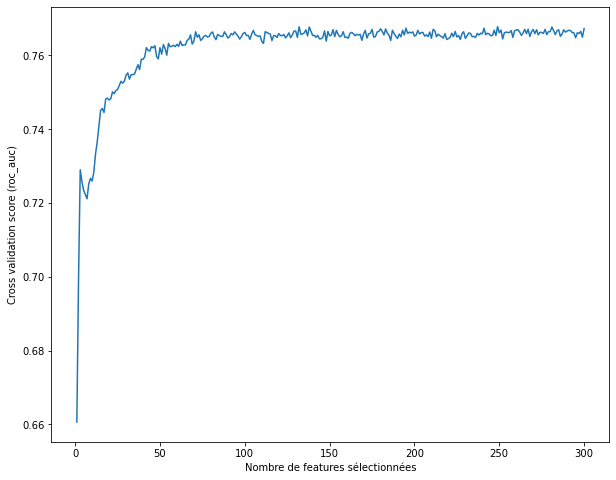

In [23]:
# Affichage des scores
print("Nombre de features optimal : %d" % rfecv_2nd_run.n_features_)

scores = rfecv_2nd_run.grid_scores_.mean(axis=1)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Nombre de features sélectionnées")
plt.ylabel("Cross validation score (roc_auc)")
plt.plot(
    range(min_features_to_select, len(rfecv_2nd_run.grid_scores_) + min_features_to_select),
    scores,
)
plt.show()

In [25]:
# Récupération des 70 features les plus importantes

feature_importances = pd.DataFrame({'feature': liste_300_feature_importances, 'rank': rfecv_2nd_run.ranking_}) # Dataframe avec les features et les rangs
feature_importances = feature_importances[feature_importances['rank'] == 1]  # Filtre sur les rank=1 (les features conservées)
feature_importances['importance'] = rfecv_2nd_run.estimator_.feature_importances_ # Ajoute les importances
feature_importances.drop(['rank'], axis=1, inplace=True)
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances = feature_importances.head(70)
liste_70_feature_importances = feature_importances.feature

In [26]:
pickle_sav('liste_70_feature_importances', liste_70_feature_importances)
pickle_sav('./Dashboard/liste_70_feature_importances', liste_70_feature_importances)
pickle_sav('./api/liste_70_feature_importances', liste_70_feature_importances)

In [27]:
data_train_rfecv = data[liste_70_feature_importances]
data_train_rfecv.shape

(307507, 70)

In [28]:
train_imputed = data_train_rfecv.values

# Définition des imputers et du scaler
imputer = SimpleImputer(strategy = 'median')

# Imputation
imputer.fit(train_imputed)
train_imputed = imputer.transform(train_imputed)

# <span style="color: #8e44ad "> 4 - Hyperparamétrisation </span>

## <span style="color: #8e44ad "> 4-1 - Recherche des hyperparamètres </span>

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_train_rfecv, data['TARGET'], test_size = 0.8, stratify=data['TARGET'])
                                                    
model = make_pipeline(StandardScaler(),CatBoostClassifier(verbose=0))

parameters = {'catboostclassifier__depth'         : [4,5,6,7,8,9, 10],
             'catboostclassifier__learning_rate' : [0.01,0.02,0.03,0.04],
              'catboostclassifier__iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
             }

grid_search = GridSearchCV(estimator=model, param_grid = parameters, scoring = 'roc_auc', cv = 2, return_train_score = True, n_jobs=-1)
grid_search.fit(X_train, y_train)

result = grid_search.fit(X_train, y_train)
print('Best Hyperparameters: %s' % result.best_params_)

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in

Best Hyperparameters: {'catboostclassifier__depth': 9, 'catboostclassifier__iterations': 100, 'catboostclassifier__learning_rate': 0.04}


## <span style="color: #8e44ad "> 4-2 - Cross validation sur le jeu épuré</span>

In [30]:
cat_boost = CatBoostClassifier(learning_rate = 0.04, depth = 8, iterations = 100, verbose = 0)

model = make_pipeline(StandardScaler(),cat_boost)

cv_results = cross_validate(model, data_train_rfecv, data['TARGET'], scoring='roc_auc', cv=5, return_train_score=True,return_estimator=True)
cv_results = pd.DataFrame(cv_results)
cv_results.loc['Mean'] = cv_results.mean()
cv_results

,fit_time,score_time,estimator,test_score,train_score
0,5.312337,0.064662,"(StandardScaler(), <catboost.core.CatBoostClas...",0.767915,0.778491
1,5.187019,0.057480,"(StandardScaler(), <catboost.core.CatBoostClas...",0.765817,0.778600
2,5.341566,0.045259,"(StandardScaler(), <catboost.core.CatBoostClas...",0.760650,0.780248
3,5.206475,0.094076,"(StandardScaler(), <catboost.core.CatBoostClas...",0.767598,0.778762
4,5.195281,0.085790,"(StandardScaler(), <catboost.core.CatBoostClas...",0.767129,0.779028
Mean,5.248535,0.069453,NaN,0.765822,0.779026


## <span style="color: #8e44ad "> 4-3 - Cross validation avec SMOTE</span>  
Les données à prédire étant "unbalanced", tentative de modification des proportions des tailles des données des classes

In [31]:
# Création du modèle
cat_boost = CatBoostClassifier(learning_rate = 0.04, depth = 8, iterations = 100, verbose = 0)

over = SMOTE(sampling_strategy=0.5, k_neighbors=6)  # Fait en sorte que la catégorie sous représentées représente 50% de la catégorie la plus représentée
steps = [('over', over), ('scale', StandardScaler()), ('model', cat_boost)]
pipeline = Pipeline_imb(steps=steps)

cv_results = cross_validate(pipeline, train_imputed, data['TARGET'], scoring='roc_auc', cv=5, return_train_score=True,return_estimator=True)
cv_results = pd.DataFrame(cv_results)
cv_results.loc['Mean'] = cv_results.mean()
cv_results

,fit_time,score_time,estimator,test_score,train_score
0,12.066209,0.743437,"(SMOTE(k_neighbors=6, sampling_strategy=0.5), ...",0.752900,0.757631
1,11.184309,0.805422,"(SMOTE(k_neighbors=6, sampling_strategy=0.5), ...",0.747997,0.757527
2,11.204273,0.778353,"(SMOTE(k_neighbors=6, sampling_strategy=0.5), ...",0.746344,0.760070
3,11.354929,0.700210,"(SMOTE(k_neighbors=6, sampling_strategy=0.5), ...",0.752659,0.757221
4,10.862213,0.805440,"(SMOTE(k_neighbors=6, sampling_strategy=0.5), ...",0.753819,0.757691
Mean,11.334386,0.766572,NaN,0.750744,0.758028


L'usage de SMOTE n'améliore pas les performances

## <span style="color: #8e44ad "> 4-4 - Test avec les classes automatiquement équilibrées </span>  

In [32]:
# Test du modèle avec auto_class_weights = 'Balanced'
cat_boost = CatBoostClassifier(learning_rate = 0.04, depth = 8, iterations = 100, auto_class_weights = 'Balanced', verbose = 0)
model = make_pipeline(StandardScaler(),cat_boost)


cv_results = cross_validate(model, data_train_rfecv, data['TARGET'], scoring='roc_auc', cv=5, return_train_score=True,return_estimator=True)
cv_results = pd.DataFrame(cv_results)
cv_results.loc['Mean'] = cv_results.mean()
cv_results

,fit_time,score_time,estimator,test_score,train_score
0,5.304189,0.085201,"(StandardScaler(), <catboost.core.CatBoostClas...",0.765914,0.781784
1,5.165344,0.088693,"(StandardScaler(), <catboost.core.CatBoostClas...",0.765210,0.781716
2,5.232443,0.089869,"(StandardScaler(), <catboost.core.CatBoostClas...",0.759417,0.783671
3,5.264259,0.044392,"(StandardScaler(), <catboost.core.CatBoostClas...",0.766307,0.781622
4,5.255434,0.056167,"(StandardScaler(), <catboost.core.CatBoostClas...",0.766515,0.781841
Mean,5.244334,0.072864,NaN,0.764673,0.782127


## <span style="color: #8e44ad "> 4-5 - Test avec de plusieurs proportions de classes </span>  

In [33]:
# Création du modèle
cat_boost = CatBoostClassifier(learning_rate = 0.04, depth = 8, iterations = 100, verbose = 0)
model = make_pipeline(StandardScaler(),cat_boost)

params_grid = { 'catboostclassifier__class_weights': [ (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1) ]}
# params_grid = { 'catboostclassifier__auto_class_weights': ['Balanced']}
grid = GridSearchCV(estimator=model, param_grid=params_grid, n_jobs=-1, cv=5, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(train_imputed, data['TARGET'])

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.764612 using {'catboostclassifier__class_weights': (2, 1)}
0.764612 (0.002786) with: {'catboostclassifier__class_weights': (2, 1)}
0.763327 (0.002685) with: {'catboostclassifier__class_weights': (3, 1)}
0.762674 (0.002574) with: {'catboostclassifier__class_weights': (4, 1)}
0.761942 (0.002380) with: {'catboostclassifier__class_weights': (5, 1)}
0.761277 (0.002626) with: {'catboostclassifier__class_weights': (6, 1)}
0.760861 (0.002518) with: {'catboostclassifier__class_weights': (7, 1)}
0.760594 (0.002565) with: {'catboostclassifier__class_weights': (8, 1)}
0.760336 (0.002346) with: {'catboostclassifier__class_weights': (9, 1)}
0.759873 (0.002344) with: {'catboostclassifier__class_weights': (10, 1)}


## <span style="color: #8e44ad "> 4-6 - Evaluation du modèle</span>  

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_imputed, data['TARGET'], test_size = 0.2, stratify=data['TARGET'])

cat_boost = CatBoostClassifier(learning_rate = 0.04, depth = 8, iterations = 100,  auto_class_weights = 'Balanced', verbose = 0)
model = make_pipeline(StandardScaler(),cat_boost)

model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f3f52787940>)])

In [35]:
def plot_matrice_de_conf(matrice_de_conf):
    group_names = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    matrice_de_conf.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         matrice_de_conf.flatten()/np.sum(matrice_de_conf)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(matrice_de_conf, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Matrice de confusion \n');
    ax.set_xlabel('\nValeurs prédites')
    ax.set_ylabel('Valeurs réelles ');

    ## Labels (ils doivent être dans l'ordre alphabétique)
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

    plt.show()
    
def evaluate_model(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    plot_matrice_de_conf(cm)
    print("La précision est égale à :" + str(metrics.precision_score(y_test, y_pred)))
    print("Le rappel est égal à :" + str(metrics.recall_score(y_test, y_pred)))

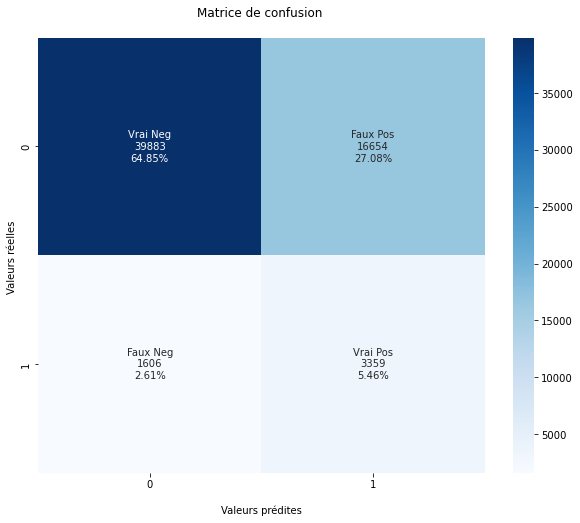

La précision est égale à :0.16784090341278168
Le rappel est égal à :0.6765357502517624


In [36]:
evaluate_model(y_test, model.predict(X_test))
# Equivalent à :
# evaluate_model(y_test, model.predict_proba(X_test)[:,1] >= 0.5)

# <span style="color: #8e44ad "> 5 - Intégration d'une fonction de coût </span>

## <span style="color: #8e44ad "> 5-1 - Définition de la fonction </span>  

La fonction de coût (FC) est de forme : FC = α.TP + β.FN + λ.FP + η.TN

Dans notre problématique métier, les VP et VN n’ont pas d’impact donc : α = η = 0

Le coût des FN est bien plus important pour la banque que les FP donc : β = 10 et λ = 1

La fonction de coût se simplifie alors en FC = 10xFN + FP

<AxesSubplot:>

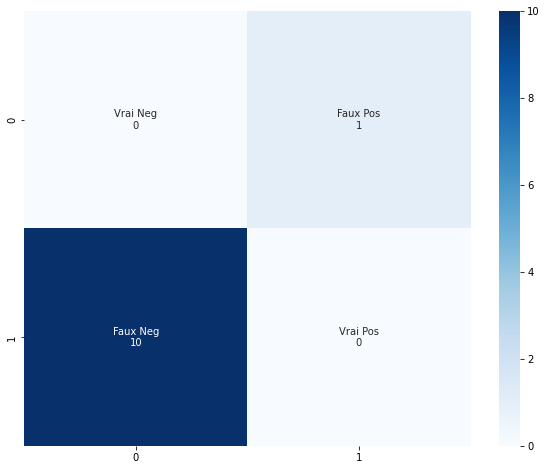

In [37]:
matrice_metier = [[0,1],[10,0]]
labels = [['Vrai Neg\n0','Faux Pos\n1'],['Faux Neg\n10','Vrai Pos\n0']]
sns.heatmap(matrice_metier, annot=labels, fmt='', cmap='Blues')

## <span style="color: #8e44ad "> 5-2 - Optimisation de la fonction de coût en fonction du seuil de prédiction </span>  

In [38]:
cat_boost = CatBoostClassifier(learning_rate = 0.04, depth = 8, iterations = 100,  auto_class_weights = 'Balanced', verbose = 0)
model = make_pipeline(StandardScaler(),cat_boost)

X_train, X_test, y_train, y_test = train_test_split(train_imputed, data['TARGET'], test_size = 0.8, stratify=data['TARGET'])

model.fit(X_train, y_train)

resultats = []
threshold = np.linspace(0, 1, 100)

for thresh in threshold:
    y_pred = model.predict_proba(X_test)[:,1] >= thresh
    CM = metrics.confusion_matrix(y_test, y_pred)
    FN = CM[1][0]
    FP = CM[0][1]
    FC = 10*FN + FP
    resultats.append([thresh, FC])

resultats = pd.DataFrame(resultats, columns=['Seuil', 'Fonction de coût'])

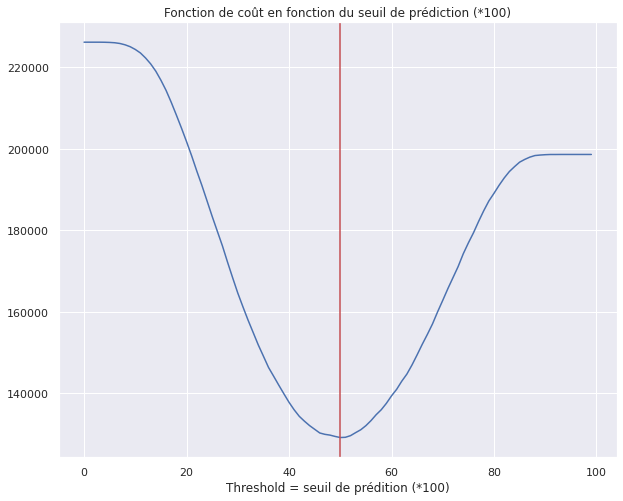

In [39]:
sns.set()

resultats['Fonction de coût'].plot()
plt.axvline(x=resultats['Fonction de coût'].idxmin(), color='r')
_ = plt.xlabel("Threshold = seuil de prédition (*100)")
_ = plt.title("Fonction de coût en fonction du seuil de prédiction (*100)")

In [40]:
print("Le seuil conduisant à minimiser la fonction de coût est de %0.3f" % round(resultats.iloc[resultats['Fonction de coût'].idxmin(),0],3))

Le seuil conduisant à minimiser la fonction de coût est de 0.505


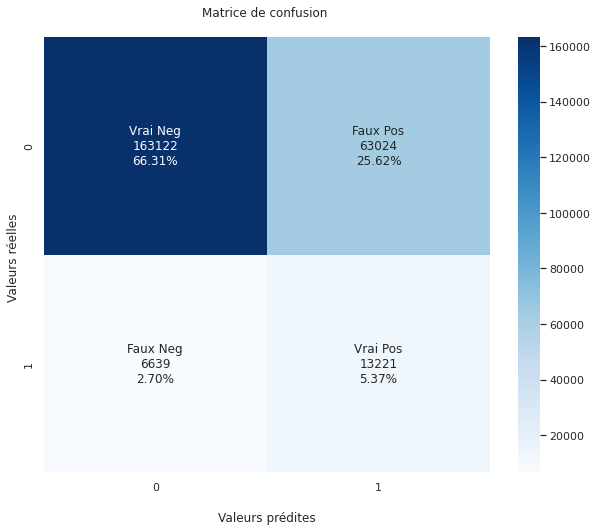

La précision est égale à :0.17340153452685422
Le rappel est égal à :0.6657099697885196


In [41]:
evaluate_model(y_test, model.predict_proba(X_test)[:,1] >= 0.495)

# <span style="color: #8e44ad "> 6 - Réalisation d'une soumission Kaggle </span>

In [42]:
cat_boost = CatBoostClassifier(learning_rate = 0.04, depth = 8, iterations = 100,  auto_class_weights = 'Balanced', verbose = 0)
model = make_pipeline(StandardScaler(),cat_boost)

model.fit(data_train_rfecv, data['TARGET'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f3f537268e0>)])

In [43]:
##### Submission dataframe
submit_CatBoost = data_submit[['SK_ID_CURR']]
submit_CatBoost['TARGET'] = model.predict_proba(data_submit[liste_70_feature_importances])[:,1]

# Save the submission to a csv file
submit_CatBoost.to_csv('Submit/CatBoost.csv', index = False)

submit_CatBoost.head()

,SK_ID_CURR,TARGET
307507,100001,0.472497
307508,100005,0.585260
307509,100013,0.207935
307510,100028,0.350317
307511,100038,0.641320


Cette soumission conduit à un score de 0.75415

In [44]:
print("La probabilité minimum est de {} et maximun de {}".format(round(submit_CatBoost.TARGET.min(), 2), round(submit_CatBoost.TARGET.max(), 2)))

La probabilité minimum est de 0.05 et maximun de 0.91


# <span style="color: #8e44ad "> 7 - Features importances </span>

## <span style="color: #8e44ad "> 7-1 - Features importances via CatBoost </span>  

In [45]:
# Initialise un vecteur pour les résultats
feature_importances = np.zeros(data_train_rfecv.shape[1])

# Création du modèle
cat_boost = CatBoostClassifier(learning_rate = 0.04, depth = 8, iterations = 100,  auto_class_weights = 'Balanced', verbose = 0)
# model = make_pipeline(StandardScaler(),cat_boost)


# Cross_validation manuelle
n_CV = 3
 
for i in range(n_CV):
    
    # Train_test_split
    X_train, X_test, y_train, y_test = train_test_split(data_train_rfecv, data['TARGET'], test_size = 0.5, stratify=data['TARGET'], random_state = i)
    
    # Entraine le modèle avec un early_stopping
    cat_boost.fit(X_train, y_train, early_stopping_rounds=100, eval_set = [(X_test, y_test)]) 
              # eval_metric = 'auc', verbose = 200)
    
    # Additionne les importances pour chaque round
    feature_importances += cat_boost.feature_importances_

feature_importances = feature_importances / n_CV
feature_importances = pd.DataFrame({'feature': data_train_rfecv.columns, 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
1,EXT_SOURCE_3,14.864476
0,EXT_SOURCE_2,13.869116
4,EXT_SOURCE_1,6.101424
7,DAYS_EMPLOYED,4.143228
2,PAYMENT_RATE,4.073774


In [46]:
def plot_feature_importances(df, Number_features=25, threshold=0.95):
    """
    Plot : - Features importances d'un modèle.
           - Features importances cumulée
    
    Paramètres:
        - df (dataframe): feature importances. Doit avoir les features dans une colonne : "feature"
        et les importances dans une colonne : "importance"
        - Number_features : Nombre de features sur le graphique des features importances
        - threshold : Valeur considérée pour l'importance cumulée
    Returns:
        Un graphique des features les plus importantes (15 par défaut)
        
        df (dataframe): features importances triées par importance avec une colonne des importances normalisées
        """
    
    # Trie des features par importance si nécessaire
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Création de 2 nouvelles colonnes : importance normalisée + importance cumulée
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # 1er graphique sur les features importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Nécessité d'inverser l'index pour avoir les plus importantes en haut
    ax.barh(list(reversed(list(df.index[:Number_features]))), df['importance_normalized'].head(Number_features), align = 'center', edgecolor = 'k')
    
    # Plot les labels
    ax.set_yticks(list(reversed(list(df.index[:Number_features]))))
    ax.set_yticklabels(df['feature'].head(Number_features))
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # 2nd graphique sur les importances cumulées
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Nombre de Features'); plt.ylabel('Importance cumulée'); 
    plt.title('Feature importance cumulée');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features requises pour %0.2f d\'importance cumulée' % (importance_index + 1, threshold))    
    
    return df

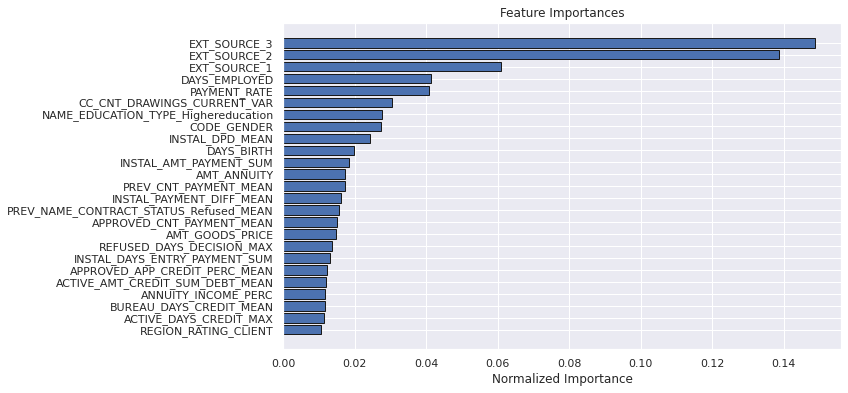

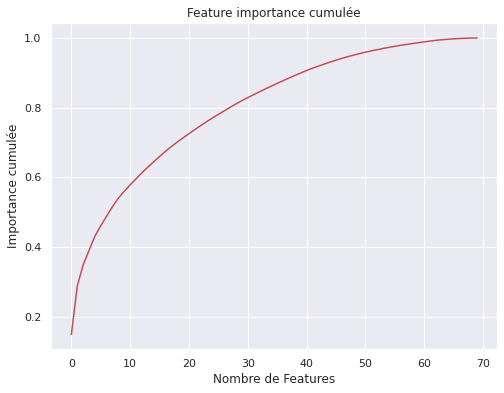

49 features requises pour 0.95 d'importance cumulée


In [47]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [48]:
# Threshold pour l'importance cumulée
threshold = 0.99

# Extract des features à supprimer en fonction du threshold
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])
print("En considérant un threshold de %0.2f, %d features sur %d seraient à conserver" %(threshold, len(features_to_keep)+1, data_train_rfecv.shape[1]))

En considérant un threshold de 0.99, 62 features sur 70 seraient à conserver


In [49]:
liste_25_features_api = feature_importances['feature'][0:25].values
pickle_sav('liste_25_features_api', liste_25_features_api)

## <span style="color: #8e44ad "> 7-2 - Features importances via shap </span>  

### <span style="color: #8e44ad "> 7-2-1 - Features importances globale </span>  

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data_train_rfecv, data['TARGET'], test_size = 0.2, stratify=data['TARGET'])

scaler = StandardScaler()
scaler.fit(X_train)
scaled_train_data = scaler.transform(X_train)
scaled_test_data = scaler.transform(X_test) 

t0= time.time()
explainer = shap.TreeExplainer(cat_boost)
shap_values = explainer.shap_values(scaled_train_data)
t1= time.time() - t0

print("Kernel SHAP - temps de traitement", round(t1,3) , " secondes. ")

Kernel SHAP - temps de traitement 9.641  secondes. 


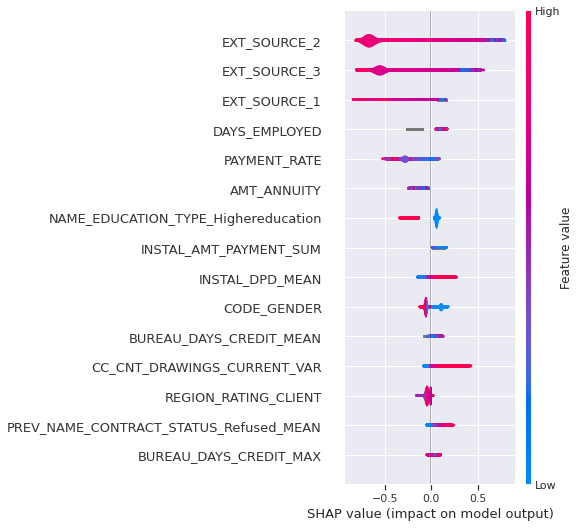

In [52]:
shap.initjs()
shap.summary_plot(shap_values, scaled_train_data, feature_names=liste_70_feature_importances.values, plot_type='violin', max_display=15)

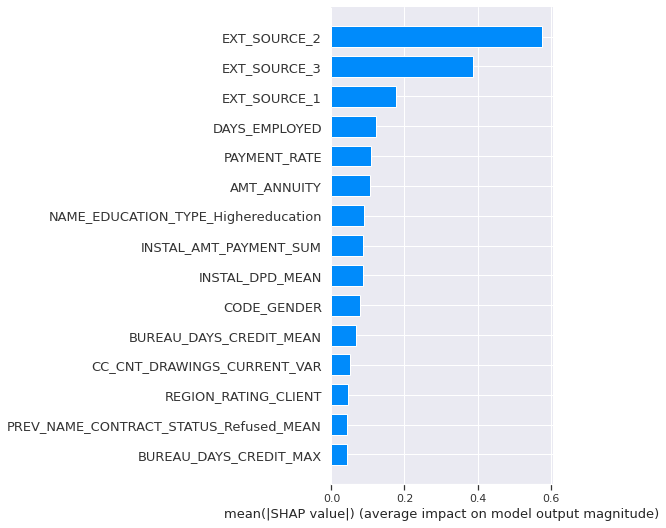

In [53]:
shap.summary_plot(shap_values, scaled_train_data, feature_names=liste_70_feature_importances.values, plot_type='bar', max_display=15, show=False)

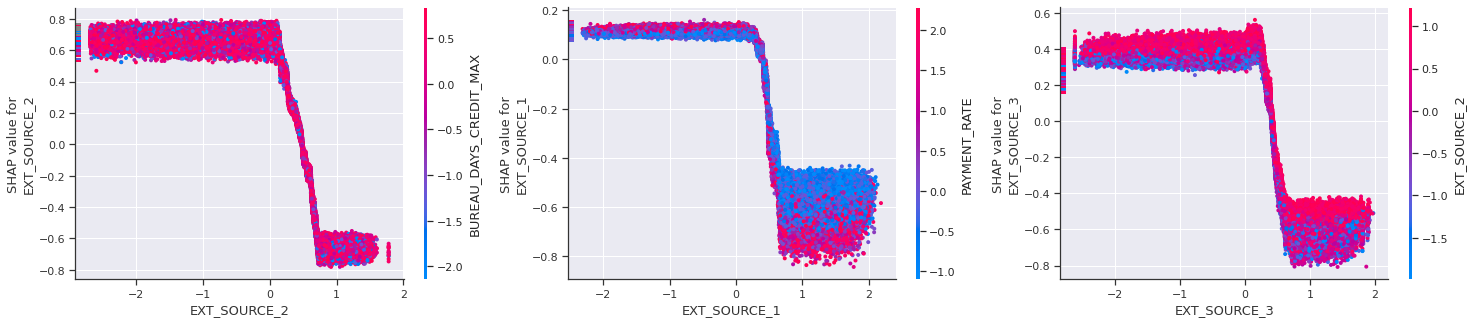

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

shap.dependence_plot('EXT_SOURCE_2', shap_values, scaled_train_data, feature_names=liste_70_feature_importances.values, ax=axes[0], show=False)
shap.dependence_plot('EXT_SOURCE_1', shap_values, scaled_train_data, feature_names=liste_70_feature_importances.values, ax=axes[1], show=False)
shap.dependence_plot('EXT_SOURCE_3', shap_values, scaled_train_data, feature_names=liste_70_feature_importances.values, ax=axes[2], show=False)

### <span style="color: #8e44ad "> 7-2-1 - Features importances locale </span>  

In [56]:
def shap_force_plot(j):
    explainerModel = shap.TreeExplainer(cat_boost)
    shap_values_Model = explainerModel.shap_values(X_test)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_test.iloc[[j]])
    return(p)

def shap_decision_plot(j):
    explainerModel = shap.TreeExplainer(cat_boost)
    shap_values_Model = explainerModel.shap_values(X_test)
    p = shap.decision_plot(explainerModel.expected_value, shap_values_Model[j], X_test.iloc[[j]], feature_names=liste_70_feature_importances.values)
    return(p)

def shap_waterfall_plot(j):
    explainerModel = shap.TreeExplainer(cat_boost)
    shap_values = explainerModel(X_test)
    p = shap.waterfall_plot(shap_values[j])
    return(p)

In [57]:
shap.initjs()
shap_force_plot(1)

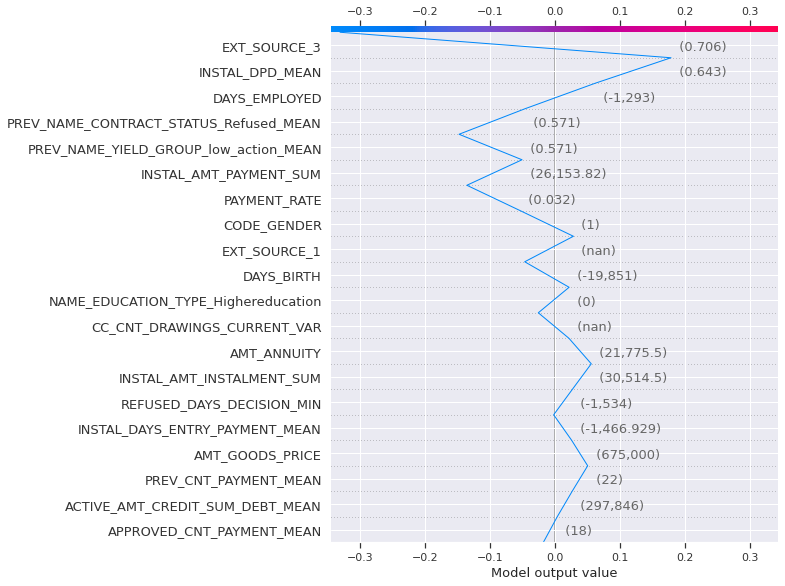

In [58]:
shap_decision_plot(1)

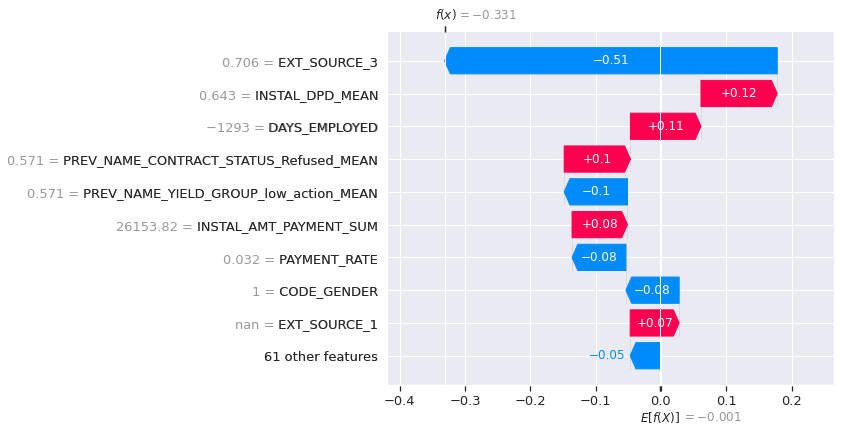

In [59]:
shap_waterfall_plot(1)

# <span style="color: #8e44ad "> 8 - Sauvegarde des données </span>

In [60]:
# Sauvegarde du modèle

cat_boost = CatBoostClassifier(learning_rate = 0.04, depth = 8, iterations = 100,  auto_class_weights = 'Balanced', verbose = 0)
model = make_pipeline(StandardScaler(),cat_boost)
model.fit(data_train_rfecv, data['TARGET'])

joblib.dump(model, './api/model_fitted_home_credit.joblib')

['./api/model_fitted_home_credit.joblib']

In [61]:
# Sauvegarde des shap_values et expected_values

cat_boost = CatBoostClassifier(learning_rate = 0.04, depth = 8, iterations = 100,  auto_class_weights = 'Balanced', verbose = 0)
cat_boost.fit(data_train_rfecv, data['TARGET'])

explainerModel = shap.TreeExplainer(cat_boost)
shap_values_Model = explainerModel.shap_values(X_test_api[liste_70_feature_importances])
exp_values = explainerModel.expected_value

pickle_sav('./Dashboard/shap_values', shap_values_Model)
pickle_sav('./Dashboard/exp_values', exp_values)

In [62]:
# Sauvegarde des valeurs de densité pour le dashboard

dico_KDE = {}
features_25 = pickle_load('liste_25_features_api.pickle')
features_to_export = list(features_25[0:5])
features_to_export.extend(['YEAR_BIRTH', 'AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_GOODS_PRICE', 'INCOME_PER_PERSON', 'AMT_ANNUITY'])
df_temp = pd.concat([X_train, y_train], axis=1)
df_temp['YEAR_BIRTH'] = -df_temp['DAYS_BIRTH']/365

liste_log = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'INCOME_PER_PERSON']

for f in features_to_export:
    if f not in liste_log:
        x0, y0 = sns.kdeplot(df_temp[df_temp['TARGET'] == 0][f]).get_lines()[0].get_data()
        plt.clf()
        x1, y1 = sns.kdeplot(df_temp[df_temp['TARGET'] == 1][f]).get_lines()[0].get_data()
        dico_KDE[f] = [x0, y0, x1, y1]
        plt.clf()
    else:
        x0, y0 = sns.kdeplot(df_temp[df_temp['TARGET'] == 0][f], log_scale=True).get_lines()[0].get_data()
        plt.clf()
        x1, y1 = sns.kdeplot(df_temp[df_temp['TARGET'] == 1][f], log_scale=True).get_lines()[0].get_data()
        dico_KDE[f] = [x0, y0, x1, y1]
        plt.clf()        
    
pickle_sav('./Dashboard/Dictionnaire_kde', dico_KDE)

<Figure size 720x576 with 0 Axes>

In [ ]:
def plot_graph(colonne, client_index):
    x0,y0 = sns.kdeplot(df_temp[df_temp['TARGET'] == 0][colonne]).get_lines()[0].get_data()
    x1,y1 = sns.kdeplot(df_temp[df_temp['TARGET'] == 1][colonne]).get_lines()[0].get_data()
    # _ = plt.axvline(x=data_submit.iloc[data_submit.index.get_loc(client_index)][colonne], color='r')
    _ = plt.legend(["Crédit refusé", "Crédit accordé", "Client"])
def plot_graph_log(colonne, client_index):
    x0,y0 = sns.kdeplot(df_temp[df_temp['TARGET'] == 0][colonne], log_scale=True).get_lines()[0].get_data()
    x1,y1 = sns.kdeplot(df_temp[df_temp['TARGET'] == 1][colonne], log_scale=True).get_lines()[0].get_data()
    # _ = plt.axvline(x=data_submit.iloc[data_submit.index.get_loc(client_index)][colonne], color='r')
    _ = plt.legend(["Crédit refusé", "Crédit accordé", "Client"])

In [ ]:
plot_graph('DAYS_EMPLOYED', 5)

In [ ]:
resultats = []
threshold = np.linspace(0, 1, 100)

for thresh in threshold:
    model.predict_proba(X_test)[:,1] >= thresh
    resultats.append([metrics.precision_score(y_test, model.predict_proba(X_test)[:,1] >= thresh),
                      metrics.recall_score(y_test, model.predict_proba(X_test)[:,1] >= thresh),
                      metrics.f1_score(y_test, model.predict_proba(X_test)[:,1] >= thresh),
                      metrics.fbeta_score(y_test, model.predict_proba(X_test)[:,1] >= thresh, beta=10)
                     ])
resultats = pd.DataFrame(resultats, columns=['Précision', 'Recall', 'F1_score', 'Fbeta_score'])

In [ ]:
sns.set()

resultats.plot()
_ = plt.yticks(np.arange(0, 1.1, 0.1))
_ = plt.xticks(np.arange(0, 105, 5))
_ = plt.xlabel("Threshold = seuil de prédition (*100)")
_ = plt.title("Précision, Recall et Score_F1 en fonction du seuil de prédiction (*100)")